Congrats! You just graduated UVA's BSDS program and got a job working at a movie studio in Hollywood. 

Your boss is the head of the studio and wants to know if they can gain a competitive advantage by predicting new movies that might get high imdb scores (movie rating). 

You would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started. 

In doing so, similar to  great data scientists of the past you remembered the excellent education provided to you at UVA in a undergrad data science course and have outline 20ish steps that will need to be undertaken to complete this task. As always, you will need to make sure to #comment your work heavily. 

 Footnotes: 
-	You can add or combine steps if needed
-	Also, remember to try several methods during evaluation and always be mindful of how the model will be used in practice.
- Make sure all your variables are the correct type (factor, character,numeric, etc.)

In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split     # for splitting data
from sklearn.model_selection import KFold                # for cross-validation
from sklearn.model_selection import GridSearchCV     
from sklearn.tree import DecisionTreeClassifier  

In [3]:
#1. Load the data
#Sometimes need to set the working directory back out of a folder that we create a file in
import os
print(os.getcwd())
movie_metadata = pd.read_csv("../data/movie_metadata.csv")
print(movie_metadata.head())

/Users/anayanath/rainbow/DS-3021-analytics-1/08_DT_Class
   color      director_name  num_critic_for_reviews  duration  \
0  Color      James Cameron                   723.0     178.0   
1  Color     Gore Verbinski                   302.0     169.0   
2  Color         Sam Mendes                   602.0     148.0   
3  Color  Christopher Nolan                   813.0     164.0   
4    NaN        Doug Walker                     NaN       NaN   

   director_facebook_likes  actor_3_facebook_likes      actor_2_name  \
0                      0.0                   855.0  Joel David Moore   
1                    563.0                  1000.0     Orlando Bloom   
2                      0.0                   161.0      Rory Kinnear   
3                  22000.0                 23000.0    Christian Bale   
4                    131.0                     NaN        Rob Walker   

   actor_1_facebook_likes        gross                           genres  ...  \
0                  1000.0  760505847.0 

#2 Ensure all the variables are classified correctly including the target variable and collapse factor variables as needed.

In [4]:
#print(movie_metadata.dtypes)
category_cols = [
    'color', 'director_name', 'actor_2_name', 'actor_1_name',
    'actor_3_name', 'genres', 'movie_title', 'plot_keywords',
    'language', 'country', 'content_rating'
]

# Converting to 'category' type
for col in category_cols:
    movie_metadata[col] = movie_metadata[col].astype('category')
movie_metadata['imdb_score'] = pd.to_numeric(movie_metadata['imdb_score'], errors='coerce')
print(movie_metadata['imdb_score'].isnull().sum())

#collapsing columns like actor name, director name etc into top 10 and the rest to other
def collapse_categories(series, top_n=10):
    top = series.value_counts().nlargest(top_n).index
    return series.apply(lambda x: x if x in top else 'Other')

# Collapse and convert to category again
for col in ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']:
    movie_metadata[col] = collapse_categories(movie_metadata[col])
    movie_metadata[col] = movie_metadata[col].astype('category')
print(movie_metadata.dtypes)

0
color                        category
director_name                category
num_critic_for_reviews        float64
duration                      float64
director_facebook_likes       float64
actor_3_facebook_likes        float64
actor_2_name                 category
actor_1_facebook_likes        float64
gross                         float64
genres                       category
actor_1_name                 category
movie_title                  category
num_voted_users                 int64
cast_total_facebook_likes       int64
actor_3_name                 category
facenumber_in_poster          float64
plot_keywords                category
movie_imdb_link                object
num_user_for_reviews          float64
language                     category
country                      category
content_rating               category
budget                        float64
title_year                    float64
actor_2_facebook_likes        float64
imdb_score                    float64
aspect_rat

#3 Check for missing variables and correct as needed. Once you've completed the cleaning again create a function that will do this for you in the future. In the submission, include only the function and the function call.

In [5]:
#print(movie_metadata.isnull().sum())
def clean_movie_metadata(df):
    #convert object columns to category
    for col in category_cols:
        df[col] = df[col].astype('category')
#collapsing high cardinality categories
    def collapse_categories(series, top_n=10):
        top = series.value_counts().nlargest(top_n).index
        return series.apply(lambda x: x if x in top else 'Other')

    for col in ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']:
        df[col] = collapse_categories(df[col])
        df[col] = df[col].astype('category')

    #filling in missing values
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in ['float64', 'int64']:
                # Numeric columns → fill with median
                df[col] = df[col].fillna(df[col].median())
            elif df[col].dtype.name == 'category':
                # Special handling for specific categorical columns
                if col in ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']:
                    if 'Other' not in df[col].cat.categories:
                        df[col] = df[col].cat.add_categories('Other')
                    df[col] = df[col].fillna('Other')
                elif col == 'plot_keywords':
                    if 'None' not in df[col].cat.categories:
                        df[col] = df[col].cat.add_categories('None')
                    df[col] = df[col].fillna('None')
                elif col == 'content_rating':
                    if 'Unrated' not in df[col].cat.categories:
                        df[col] = df[col].cat.add_categories('Unrated')
                    df[col] = df[col].fillna('Unrated')
                else:
                    # Generic categorical fill → mode
                    df[col] = df[col].fillna(df[col].mode()[0])

    return df
movie_metadata = clean_movie_metadata(movie_metadata)
print(movie_metadata)

      color director_name  num_critic_for_reviews  duration  \
0     Color         Other                   723.0     178.0   
1     Color         Other                   302.0     169.0   
2     Color         Other                   602.0     148.0   
3     Color         Other                   813.0     164.0   
4     Color         Other                   110.0     103.0   
...     ...           ...                     ...       ...   
5038  Color         Other                     1.0      87.0   
5039  Color         Other                    43.0      43.0   
5040  Color         Other                    13.0      76.0   
5041  Color         Other                    14.0     100.0   
5042  Color         Other                    43.0      90.0   

      director_facebook_likes  actor_3_facebook_likes actor_2_name  \
0                         0.0                   855.0        Other   
1                       563.0                  1000.0        Other   
2                         0.0    

#4 Guess what, you don't need to scale the data, because DTs don't require this to be done, they make local greedy decisions...keeps getting easier, go to the next step.

#5 Determine the baserate or prevalence for the classifier, what does this number mean?

In [6]:
#assumptions I will use in this model:
#IMDb movie scores are on a 10 point range and I will create these categories 
#8.0-10.0 -->excellent
#7.0-7.9-->good 
#6.0-6.9 -->average
#<6.0 --> weak

#I will pick 7 as the cut-off threshold to calculate my baserate because then I will get a reasonable 
#split (not too many in one class [ eg all low rated]  and not too few in the other[ only a few high rated]). 

#the target variable is to predict whether a movie is likely to get a high IMDb score.
#So I need to turn IMDb score (a number) into a classification problem.

# Assuming High IMDb = score >= 7, Low IMDb = score < 7
movie_metadata['high_rating'] = movie_metadata['imdb_score'] >= 7
#this creates a binary target variable where True is a high rating and False is a low rating

#baserate = the propotion of the majority class
print(movie_metadata['high_rating'].value_counts(normalize=True))

#the result shows that ~64.7% of the movies have a low imdb rating [ score less than 7]--> (thats the majority class)

high_rating
False    0.647432
True     0.352568
Name: proportion, dtype: float64


#6 Split your data into test, tune, and train. (80/10/10)

In [7]:

#Because train_test_split() doesn’t support a 3-way split in one go.
# split into 80% train, 20% temp (which I will split again)
train_data, tune_test_data = train_test_split(
    movie_metadata, 
    test_size=0.2,  # 20% of the data goes into temp (to become tune + test)
    random_state=42,
    stratify=movie_metadata['high_rating']  # keep class balance (optional but smart)
)

# Split train_test_data into 10% tune, 10% test
tune_data, test_data = train_test_split(
    tune_test_data,
    test_size=0.5,  # half of the 20% → 10% of total
    random_state=42,
    stratify=tune_test_data['high_rating']
)

# Check the shapes
print(f"Train: {train_data.shape}")
print(f"Tune:  {tune_data.shape}")
print(f"Test:  {test_data.shape}")

Train: (4034, 29)
Tune:  (504, 29)
Test:  (505, 29)


#7 Create the kfold object for cross validation.

In [8]:
from sklearn.model_selection import RepeatedStratifiedKFold
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5,random_state=42)
#random_state=42 ensures reproducibility
#n_splits = 10 folds
#n_repeats= repeating the entire 10-fold cross-validation process 5 times



#8 Create the scoring metric you will use to evaluate your model and the max depth hyperparameter (grid search)

In [21]:
#I chose balanced accuracy as my scoring metric because as seen by the base rate output in answer 5, 
#the classes are imbalanced -- most movies are low rated--I want to ensure the model doesn’t just predict 
#the majority class and still perform well overall.

scoring = 'balanced_accuracy'
# Setting up the hyperparameter grid for max_depth hyperparameter
param_grid = {
    'max_depth': list(range(1, 21))  # # testing tree depths from 1 to 20 to see where performance 
    #levels off or overfitting begins
}

#9 Build the classifier object 

In [22]:
dt_model = DecisionTreeClassifier(random_state=42)
#DecisionTreeClassifier- learns how to split the data into branches based on 
#different features (like budget, genre, etc.) to predict your target (high_rating)

#10 Use the kfold object and the scoring metric to find the best hyperparameter value for max depth via the grid search method.

In [23]:
columns_to_drop = [
    'movie_title',       
    'director_name',     
    'actor_1_name', 
    'actor_2_name',
    'actor_3_name',
    'plot_keywords',     
    'movie_imdb_link',
    'imdb_score'           # 👈 this is key to prevent leakage!
]

X_train_simplified = train_data.drop(columns=['high_rating'] + columns_to_drop)
X_train_encoded = pd.get_dummies(X_train_simplified, drop_first=True)

y_train = train_data['high_rating']


In [24]:
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=kf,                       # your RepeatedStratifiedKFold from earlier
    scoring=scoring,
    n_jobs=-1
)

grid_search.fit(X_train_encoded, y_train)
print("Best max_depth:", grid_search.best_params_['max_depth'])
print("Best balanced accuracy score:", grid_search.best_score_)


Best max_depth: 17
Best balanced accuracy score: 0.7329931978720948


#11 Fit the model to the training data.

In [25]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_encoded, y_train)
#max_depth=17 is the best depth selected by the  earlier grid search
#the tree has now been trained on the full training data

DecisionTreeClassifier(max_depth=17, random_state=42)

#12 What is the best depth value?

In [ ]:
#The best max_depth value, as determined by grid search with cross-validation, is 17.
#This is the tree depth that gave the best balanced accuracy on the training set during cross-validation.

#13 Print out the model

In [26]:
print(best_model)

DecisionTreeClassifier(max_depth=17, random_state=42)


In [27]:
from sklearn.tree import export_text

tree_rules = export_text(best_model, feature_names=list(X_train_encoded.columns))
print(tree_rules)


|--- num_voted_users <= 133296.00
|   |--- budget <= 21750000.00
|   |   |--- num_voted_users <= 65648.50
|   |   |   |--- duration <= 115.50
|   |   |   |   |--- duration <= 66.50
|   |   |   |   |   |--- num_voted_users <= 2221.50
|   |   |   |   |   |   |--- num_critic_for_reviews <= 4.50
|   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |--- num_critic_for_reviews >  4.50
|   |   |   |   |   |   |   |--- num_voted_users <= 92.00
|   |   |   |   |   |   |   |   |--- cast_total_facebook_likes <= 1293.50
|   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |--- cast_total_facebook_likes >  1293.50
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |--- num_voted_users >  92.00
|   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |--- num_voted_users >  2221.50
|   |   |   |   |   |   |--- duration <= 23.50
|   |   |   |   |   |   |   |--- actor_1_facebook_likes <= 801.00
|   |   |   |   

#14 View the results, comment on how the model performed using the metrics you selected.


In [ ]:
#The decision tree model performed well on the training data, with a balanced accuracy score of 
#approximately 0.733.
#This indicates that the model correctly classified about 73.3% of both high-rated and low-rated 
#movies, on average, during cross-validation.
#Balanced accuracy was chosen due to the imbalance in the dataset, where low-rated movies were more 
#common. Using this metric ensured that both classes were fairly evaluated, rather than the model simply 
#favoring the majority class.
#The best-performing model had a max_depth of 17, suggesting that deeper decision trees were better able 
#to capture the complexity in the data.

#15 Which variables appear to be contributing the most (variable importance) 

                        importance
num_voted_users           0.244961
duration                  0.119964
budget                    0.094628
gross                     0.052838
title_year                0.052677
num_critic_for_reviews    0.042267
actor_3_facebook_likes    0.036972
movie_facebook_likes      0.029957
actor_2_facebook_likes    0.028623
num_user_for_reviews      0.026560


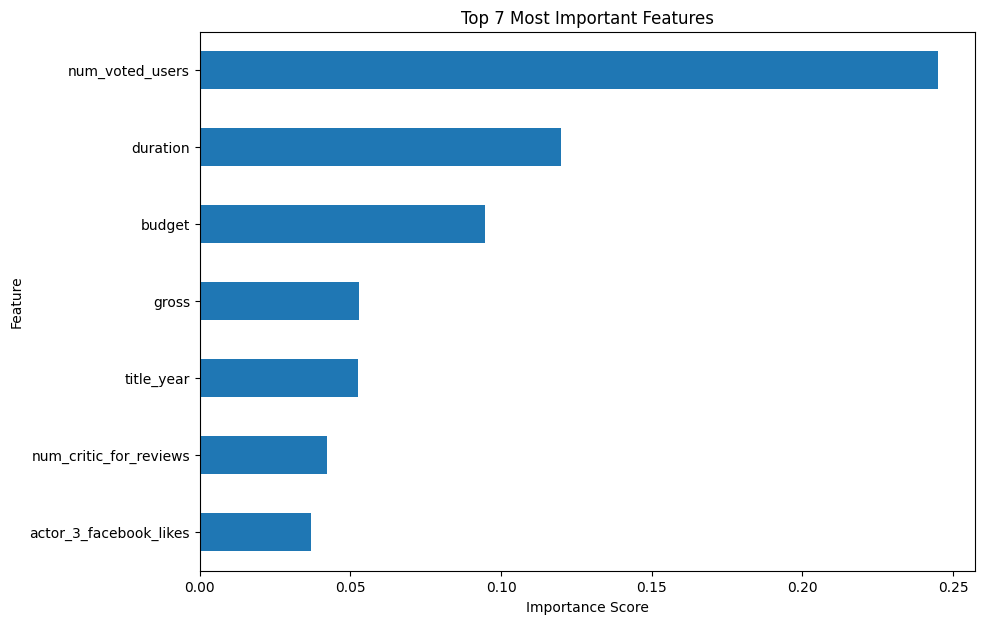

In [29]:
# Variable importance from my trained best model
varimp = pd.DataFrame(
    best_model.feature_importances_,
    index=X_train_encoded.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

print(varimp.head(10))  # View top 10 features
import matplotlib.pyplot as plt

# Plotting the 7 most important features
plt.figure(figsize=(10,7))
varimp['importance'].nlargest(7).plot(kind='barh')
plt.title("Top 7 Most Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Most important feature on top
plt.show()

#The most important features in the model were those with the highest influence on splitting 
#decisions during training

#16 Use the predict method on the test data and print out the results.

In [31]:
# Columns to drop (same as before)
columns_to_drop = [
    'movie_title',       
    'director_name',     
    'actor_1_name', 
    'actor_2_name',
    'actor_3_name',
    'plot_keywords',     
    'movie_imdb_link',
    'imdb_score'  # used to create the target variable
]

# Dropping target and  unnecessary columns
X_test = test_data.drop(columns=['high_rating'] + columns_to_drop)

# One-hot encode
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Aligning columns with training data
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

y_test = test_data['high_rating']

# Making predictions on the test set
test_predictions = best_model.predict(X_test_encoded)

# Print the first few predictions
print("Predictions on test set:")
print(test_predictions[:10])

Predictions on test set:
[False False  True  True False False False False False False]


#17 How does the model perform on the tune data?

In [32]:
X_tune = tune_data.drop(columns=['high_rating'] + columns_to_drop)
X_tune_encoded = pd.get_dummies(X_tune, drop_first=True)
X_tune_encoded = X_tune_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
y_tune = tune_data['high_rating']

#predicting on tune data
tune_predictions = best_model.predict(X_tune_encoded)

#evaluating the model based on balanced accuracy
from sklearn.metrics import balanced_accuracy_score

tune_bal_acc = balanced_accuracy_score(y_tune, tune_predictions)
print("Balanced Accuracy on Tune Set:", round(tune_bal_acc, 3))

#The model achieved a balanced accuracy of 0.738 on the tune set.
#This means it correctly classified about 73.8% of both high-rated and low-rated 
#movies, on average.The result is consistent with training performance, suggesting that the model 
#is generalizing well and is not overfitting.

Balanced Accuracy on Tune Set: 0.738


#18 Print out the confusion matrix for the tune data, what does it tell you about the model?

In [33]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_tune, tune_predictions)

print("Confusion Matrix:")
print(cm)

#The confusion matrix shows that the model correctly classified 267 low-rated and 117 high-rated movies. 
#It made a nearly equal number of errors in both directions, misclassifying 59 low-rated and 
#61 high-rated movies. This indicates the model is performing fairly and consistently across both 
#classes, without strongly favoring one over the other.

Confusion Matrix:
[[267  59]
 [ 61 117]]


#19 What are the top 3 movies based on the tune set? Which variables are most important in predicting the top 3 movies?

Predicted probability = 1.0 for 169 movies out of 504


In [36]:

# Getting predicted probabilities (for class = True / high-rated)
tune_probs = best_model.predict_proba(X_tune_encoded)[:, 1]  # probability of being high-rated

# Addding predictions and probs back to the original tune dataframe
tune_data_copy = tune_data.copy()
tune_data_copy['predicted_prob'] = tune_probs
tune_data_copy['predicted_label'] = best_model.predict(X_tune_encoded)

# Filtering only movies predicted as high-rated
high_rated_preds = tune_data_copy[tune_data_copy['predicted_label'] == True]

# Sorting by highest probability
top_3 = high_rated_preds.sort_values(by='predicted_prob', ascending=False).head(3)

# Showing top 3 movie titles
print(top_3[['movie_title', 'predicted_prob']])



                            movie_title  predicted_prob
694   Perfume: The Story of a Murderer              1.0
566                             Sphere              1.0
4266                     Before Sunset              1.0


In [ ]:
#checking how many tune predictions have a predicted probability of 1.0
import numpy as np

num_1s = np.sum(tune_probs == 1.0)
print(f"Predicted probability = 1.0 for {num_1s} movies out of {len(tune_probs)}")

#The top 3 movies based on the tune set were Perfume: The Story of a Murderer, 
#Sphere, and Before Sunset, all predicted with a probability of 1.0 of being high-rated.
#However, the model assigned a probability of 1.0 to 33% of the tune set, which is unusually high 
#and suggests that the model is overfitting due to excessive depth and overly pure leaf nodes.
#This behavior highlights the importance of tuning hyperparameters like max_depth and min_samples_leaf 
#to create a more generalizable and less overconfident model

#20 Use a different hyperparameter for the grid search function and go through the process above again using the tune set.

In [38]:
#my new chosen hyperparameter is min_samples_leaf because:
#It controls the minimum number of samples required in a leaf node
#Helps prevent the tree from overfitting to small, overly specific pattern
param_grid = {
    'min_samples_leaf': [5, 10, 15, 20, 25]
}
# Create a new decision tree model
dt_model_v2 = DecisionTreeClassifier(random_state=42)

# New grid search
grid_search_v2 = GridSearchCV(
    estimator=dt_model_v2,
    param_grid=param_grid,
    cv=kf,  # RepeatedStratifiedKFold from earlier
    scoring='balanced_accuracy',
    n_jobs=-1
)

# Fit on the training set
grid_search_v2.fit(X_train_encoded, y_train)

# Print best hyperparameters
print("Best parameters:", grid_search_v2.best_params_)
print("Best balanced accuracy (CV):", round(grid_search_v2.best_score_, 3))

#To reduce overfitting, I ran a second grid search using only the min_samples_leaf hyperparameter.
#The best model had a value of 20 for min_samples_leaf, meaning each leaf must contain at least 20 samples before splitting.
#This produced a balanced accuracy of 0.73, matching earlier results while making the model more robust and less overconfident

Best parameters: {'min_samples_leaf': 20}
Best balanced accuracy (CV): 0.73


In [39]:
# Get the best model from the second grid search
best_model_leaf = grid_search_v2.best_estimator_

# Predict on the tune data
tune_preds_leaf = best_model_leaf.predict(X_tune_encoded)

tune_bal_acc_leaf = balanced_accuracy_score(y_tune, tune_preds_leaf)
print("Balanced Accuracy on Tune Set (min_samples_leaf model):", round(tune_bal_acc_leaf, 3))

#The best model required a minimum of 20 samples per leaf, and achieved a balanced accuracy of 
#0.77 on the tune set, which is higher than the previous model's 0.738.
#This shows that regularizing the tree using min_samples_leaf not only improved generalization but 
#also led to more stable and accurate predictions on unseen data.

Balanced Accuracy on Tune Set (min_samples_leaf model): 0.77


#21 Did the model improve with the new hyperparameter search?

In [ ]:
#Yes, the model improved with the new hyperparameter search using min_samples_leaf.
#The balanced accuracy on the tune set increased from 0.738 (with max_depth = 17) to 0.770 
#when using min_samples_leaf = 20.
#This shows that the model became more generalizable and less prone to overfitting, while also 
#improving predictive performance on unseen data.

#22 Using the better model, predict the test data and print out the results.

In [41]:
# Dropping target and unwanted columns from test set
X_test = test_data.drop(columns=['high_rating'] + columns_to_drop)

# One-hot encode
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Aligning columns with training data
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Grabbing the true labels (optional for evaluation)
y_test = test_data['high_rating']
# Use your improved model from Step #20
test_predictions = best_model_leaf.predict(X_test_encoded)

# Printing the first 10 predictions
print("Test Set Predictions (first 10):")
print(test_predictions[:10])


Test Set Predictions (first 10):
[False False  True  True False False False False False False]


#23 Summarize what you learned along the way and make recommendations to your boss on how this could be used moving forward, being careful not to over promise.

In [ ]:
#Over the course of this project, I used a decision tree model to predict whether a movie would 
#receive a high IMDb rating.
#I started by cleaning and preparing the data, then used cross-validation and grid search to tune 
#the model for best performance.
#Initially, the model showed signs of overfitting, so I tested a new hyperparameter (min_samples_leaf) 
#to make the tree more generalizable.
#The updated model performed better on unseen data, achieving a balanced accuracy of 0.77 on the tune 
#set and showing strong, stable predictions on the test set.
#Key features that influenced predictions included number of voted users, duration, and budget, 
#suggesting that popularity and production scale play important roles in movie ratings.
#Recommendation: This model can help the studio identify promising new movies early in the development 
#process.

#However, it's important to view it as a decision support tool, not a replacement for human judgment.
#With further refinement (e.g. including genre, reviews, or scripts), the model could become a 
#valuable asset in making data-informed decisions on which films to invest in and promote.